# 00.Library Import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from tqdm import tqdm 
import folium as f
import warnings 
warnings.filterwarnings('ignore')
tqdm.pandas()

from sklearn import *
import catboost

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import matplotlib.font_manager as fm
import matplotlib as mat
## 폰트 경로
font_path = './data/NanumBarunGothic.ttf' 
## FontProperties 인스턴스 생성
font_prop = fm.FontProperties(fname=font_path)
## 폰트 이름
font_name = font_prop.get_name()
plt.rcParams['font.family']= 'NanumBarunGothic'

<hr>

# 1. Modeling Test

## 1-1 Data Reading

In [15]:
def data_spliter(X,y):
    X_tr,X_te,y_tr,y_te = model_selection.train_test_split(X,y,test_size=0.2,random_state=1997)#,stratify=True)
    return X_tr,X_te,y_tr,y_te

In [16]:
feature_data = pd.read_csv("./data/4개시군구_종합.csv",index_col=0) # 시/구단위 피쳐 데이터

#### * 안전지수 데이터 전처리

In [17]:
"""안전지수 데이터"""
seoul_class = pd.read_csv("./data/91.서울_지역안전지수.csv",index_col=0) 
ggi_class = pd.read_csv("./data/92.경기도_지역안전지수.csv",index_col=0)
gnam_class = pd.read_csv("./data/93.경상남도_지역안전지수.csv",index_col=0)
total_class = pd.read_csv("./data/94.전국_지역안전지수.csv",index_col=0)

<hr>

## 1-2 Data Preprocessing & split

In [18]:
"""안전지수 중 필요한 부분만 인덱싱"""
test_index = [26,27,28,29,32,33,34,35,36]
suwon_class = pd.Series(ggi_class.loc[2,:])
jinju_class = pd.Series(gnam_class.loc[2,:])
chang_class = pd.Series(gnam_class.loc[3,:])

cleaned_class = pd.concat([pd.DataFrame([suwon_class,jinju_class,chang_class]),seoul_class])
cleaned_class.drop(1,inplace=True)
cleaned_class.reset_index(drop=True,inplace=True)

#### * 안전지수 존재 유무를 기준으로 train/test 분할

In [19]:
"""
안전지수가 있는 지역 : train data
없는 지역 : test data
"""
train_data = feature_data.copy()
test_data = feature_data.loc[test_index,:]
for i in test_index:
    train_data.drop(i,inplace=True)
test_data.reset_index(drop=True,inplace=True)    
test_sgg = test_data['sgg_nm']
del test_data['sgg_nm']
test_data = pd.get_dummies(test_data)
test_data['sido_서울특별시'] = 0

train_data = train_data.sort_values('sgg_nm')
train_data.reset_index(drop=True,inplace=True)

cleaned_class = cleaned_class.sort_values('지역_소분류')
cleaned_class.reset_index(drop=True,inplace=True)

for i in range(len(cleaned_class['지역_소분류'])):
    if cleaned_class['지역_소분류'][i] == train_data['sgg_nm'][i]:
        print(cleaned_class['지역_소분류'][i])
    else:
        print("**",cleaned_class['지역_소분류'][i])

강남구
강동구
강북구
강서구
관악구
광진구
구로구
금천구
노원구
도봉구
동대문구
동작구
마포구
서대문구
서초구
성동구
성북구
송파구
수원시
양천구
영등포구
용산구
은평구
종로구
중구
중랑구
진주시
창원시


In [20]:
concated_train_data = pd.concat([train_data,cleaned_class],axis=1)

concated_train_data['sgg_nm'] == concated_train_data['지역_소분류']
del concated_train_data['지역_대분류']
del concated_train_data['지역_소분류']
del concated_train_data['sgg_nm']

In [21]:
concated_train_data.shape

(28, 100)

In [22]:
dummies_train_data = pd.get_dummies(concated_train_data)

#### * 병합데이터

In [23]:
concated_train_data.iloc[:,50:]

conv_cnt      cctv밀도       보안등밀도      비상벨밀도     유흥업소밀도      편의점밀도  \
0        743  155.330400  204.068953  35.623451   4.456096  18.811815   
1        349  129.447436  305.620220   0.081444   6.271221  14.212053   
2        216   97.181700  356.657262   0.930778   5.415436   9.138549   
3        501   57.248153  206.996378  20.499233   3.959805  12.096721   
4        418  163.582813  401.955038  33.217188   5.040083  14.139292   
5        365  378.561858  536.305735  89.042345  11.196240  21.395955   
6        317  180.986382  388.410095  40.550491   6.410556  15.753071   
7        267  325.800417  481.324012  50.483697   6.147178  20.516205   
8        307   55.013021  114.549585   1.685792   3.455874   8.625637   
9        227    0.096715  306.489511  34.716618   3.191592  10.977141   
10       334    0.631942  567.627777   0.140432   6.530070  23.452080   
11       305  123.744259  539.581104  67.363738   3.844126  18.610453   
12       388   97.099752  318.988185  34.349352   3.351156  16.253108   
13       265  166.313250  392.266363  22.668801   3.900617  14.980629   
14       409  149.382603  162.862016   0.213282   2.580710   8.723227   
15       262  193.633347  370.426424  48.914140   4.998525  15.590638   
16       377  157.831954  519.037592  42.169773   2.925071  15.315997   
17       441   61.789809  238.772286  25.991889   5.966320  13.025481   
18      1033   99.744376   89.466132   1.675890   4.136065   8.528053   
19       249  167.636426  462.834866  38.817451   4.637483  14.255967   
20       479  153.992170  323.998874  44.987392   4.686187  19.518986   
21       242   93.605919  456.614238  46.757298   3.196300  11.050065   
22       333  122.696657  270.201201  17.825424   3.491232  11.178656   
23       265   66.385210  397.477796   4.542365   2.375365  11.043365   
24       317  231.296777  608.633497  61.084014   5.917827  31.795784   
25       277  242.991389  437.265941  96.140305   8.730230  14.927615   
26       336    3.799902    8.630785   1.070257   0.339452   0.471306   
27       971    7.680745   33.031620   0.136511   0.960930   1.299530   

    공원및놀이시설밀도  녹지지역_use_ratio  상업지역_use_ratio  주거지역_use_ratio  ...  등급_교통  \
0   18.204166        0.343676        0.049283        0.408079  ...      3   
1   18.039941        0.429425        0.027996        0.529296  ...      4   
2   11.380878        0.525758        0.011825        0.462417  ...      2   
3   17.674250        0.523756        0.031962        0.373774  ...      4   
4   14.646683        0.468344        0.013315        0.518341  ...      3   
5   15.123716        0.000000        0.000000        0.000000  ...      3   
6   24.797420        0.255766        0.025522        0.510194  ...      5   
7   19.901488        0.222622        0.011497        0.449158  ...      4   
8   24.865436        0.590953        0.016738        0.392309  ...      3   
9   19.874911        0.523703        0.012663        0.391616  ...      2   
10  23.732943        0.000000        0.000000        0.000000  ...      3   
11  24.285116        0.000000        0.000000        0.000000  ...      2   
12  20.400164        0.399863        0.039428        0.560709  ...      4   
13  20.068390        0.106591        0.016029        0.877380  ...      5   
14  13.266131        0.563859        0.028362        0.407779  ...      2   
15  23.504970        0.254601        0.030419        0.592921  ...      4   
16  19.744229        0.258880        0.016138        0.724982  ...      4   
17  22.004497        0.310187        0.068998        0.620815  ...      4   
18  16.445191        0.536209        0.048813        0.379054  ...      1   
19  36.126566        0.222050        0.045620        0.727013  ...      3   
20  18.174255        0.000000        0.000000        0.000000  ...      3   
21  11.598002        0.000000        0.000000        0.000000  ...      4   
22  16.684060        0.466820        0.018011        0.515169  ...      1   
23   7.501154        0.000000        0

## 1-3 Target columns

In [24]:
dummies_train_data.columns

Index(['총인구 (명)', '남자 (명)', '여자 (명)', '내국인-계 (명)', '내국인-남자 (명)', '내국인-여자 (명)',
       '외국인-계 (명)', '외국인-남자 (명)', '외국인-여자 (명)', '가구-계 (가구)',
       ...
       '등급_감염병', '점수_화재', '점수_생활안전', '점수_교통', '점수_범죄', '점수_자살', '점수_감염병',
       'sido_경기도', 'sido_경상남도', 'sido_서울특별시'],
      dtype='object', length=102)

In [25]:
dummies_train_data = dummies_train_data[['총인구 (명)', '남자 (명)', '여자 (명)', '내국인-계 (명)', '내국인-남자 (명)',
 '내국인-여자 (명)', '외국인-계 (명)', '외국인-남자 (명)', '외국인-여자 (명)', '가구-계 (가구)', '일반가구 (가구)', '집단가구 (가구)', '외국인가구 (가구)', '주택-계 (호)', '단독주택 (호)', '아파트 (호)', '연립주택 (호)', '다세대주택 (호)', '비거주용 건물내 주택 (호)', '주택이외의 거처 (호)', '세대당 인구수', '성비', '외국인 비율', 'poor_num', 'single_20대', 'single_65세 이상', 'single_합계', 'case_type', '교통_case_cnt', '기타_case_cnt',
 '서비스_case_cnt', '시비/폭력_case_cnt', '절도/경범_case_cnt', '교통신고비율', '기타및서비스비율',
 '절도폭력및경범비율', 'house_ratio', 'single_ratio', 'report_ratio', 'report_traffic_ratio',
 'report_vio_ratio', 'report_crime_ratio', 'total_area', 'securitylight_cnt', 'cctv_cnt',
 'bell_cnt', 'park_cnt', 'pub_cnt', 'play_cnt', 'conv_cnt', 'cctv밀도', '보안등밀도','비상벨밀도', '유흥업소밀도', '편의점밀도',
 '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio', '주거지역_use_ratio', '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio', 'plan_total_area', '공공용지_plan_use_ratio', '공원용지_plan_use_ratio',
 '녹지_plan_use_ratio', '도로용지_plan_use_ratio', '시설용지_plan_use_ratio', '업무용지_plan_use_ratio', '주거용지_plan_use_ratio',
 '학교용지_plan_use_ratio', 'police_cnt', 'security_cnt', 'remain_area_ratio',
 'case_for_sec', 'OLD_YEAR', 'area_old_level_1', 'area_old_level_2', 'area_old_level_3', 'area_old_level_4', 'acc_num', 'tot_vic_num', 'total_dmg', '인구10만명당자살율',
 '주민1인당 부담금액', 'PNILP', 'report_for_area', 'sido_경기도', 'sido_경상남도', 'sido_서울특별시','등급_화재',
 '등급_생활안전', '등급_교통', '등급_범죄', '등급_자살', '등급_감염병', '점수_화재', '점수_생활안전', '점수_교통', '점수_범죄', '점수_자살', '점수_감염병']]

In [26]:
dummies_X_train = dummies_train_data.iloc[:,:-12]

## 1-4 y data split

In [27]:
fire_class = dummies_train_data.loc[:,'등급_화재']
life_class = dummies_train_data.loc[:,'등급_생활안전']
traffic_class = dummies_train_data.loc[:,'등급_교통']
crime_class = dummies_train_data.loc[:,'등급_범죄']
suicide_class = dummies_train_data.loc[:,'등급_자살']

fire_score = dummies_train_data.loc[:,'점수_화재']
life_score = dummies_train_data.loc[:,'점수_생활안전']
traffic_score = dummies_train_data.loc[:,'점수_교통']
crime_score = dummies_train_data.loc[:,'점수_범죄']
suicide_score = dummies_train_data.loc[:,'점수_자살']

## 1-5 train / test data split (점수 데이터가 있는 것 끼리)

In [28]:
# X_tr,X_te,y_tr,y_te = data_spliter(dummies_X_train,traffic_class)
X_tr,X_te,y_tr1,y_te1 = data_spliter(dummies_X_train,fire_score)
X_tr,X_te,y_tr2,y_te2 = data_spliter(dummies_X_train,life_score)
X_tr,X_te,y_tr3,y_te3 = data_spliter(dummies_X_train,traffic_score)
X_tr,X_te,y_tr4,y_te4 = data_spliter(dummies_X_train,crime_score)
X_tr,X_te,y_tr5,y_te5 = data_spliter(dummies_X_train,suicide_score)

## 1-6 model train

In [29]:
# model 1 : 안전지수-화재 예측 모델
# model 2 : 안전지수-생활안전 예측 모델
# model 3 : 안전지수-교통 예측 모델
# model 4 : 안전지수-범죄 예측 모델
# model 5 : 안전지수-자살 예측모델
model1 = catboost.CatBoostRegressor(logging_level='Silent').fit(X_tr,y_tr1)
model2 = catboost.CatBoostRegressor(logging_level='Silent').fit(X_tr,y_tr2)
model3 = catboost.CatBoostRegressor(logging_level='Silent').fit(X_tr,y_tr3)
model4 = catboost.CatBoostRegressor(logging_level='Silent').fit(X_tr,y_tr4)
model5 = catboost.CatBoostRegressor(logging_level='Silent').fit(X_tr,y_tr5)

## 1-7 data prediction

In [30]:
pred1 = model1.predict(X_te)
pred2 = model2.predict(X_te)
pred3 = model3.predict(X_te)
pred4 = model4.predict(X_te)
pred5 = model5.predict(X_te)

## 1-8 model scoring ( RMSE based on )

In [31]:
print(metrics.mean_squared_error(pred1,y_te1)**0.5)
print(metrics.mean_squared_error(pred2,y_te2)**0.5)
print(metrics.mean_squared_error(pred3,y_te3)**0.5)
print(metrics.mean_squared_error(pred4,y_te4)**0.5)
print(metrics.mean_squared_error(pred5,y_te5)**0.5)

0.7761397579083243
0.7923920820976423
1.2829540925090017
1.7137984944754932
0.8107370502680434


In [32]:
te_data_set = pd.concat([test_sgg,test_data],axis=1)
tr_data_set = pd.concat([train_data['sgg_nm'],dummies_train_data],axis=1)

In [33]:
tr_data_set.to_csv("./data/09.tr_dataset.csv")
te_data_set.to_csv("./data/09.te_dataset.csv")

<hr>

# 2. 구단위 안전지수 값 생성용 모델.

## 2-1 Data reading

In [34]:
tr_dataset = pd.read_csv("./data/09.tr_dataset.csv",index_col=0)
te_dataset = pd.read_csv("./data/09.te_dataset.csv",index_col=0)
tr_dataset['성비']*=100
te_dataset['성비']*=100

In [35]:
tr_dataset.describe()

총인구 (명)         남자 (명)         여자 (명)     내국인-계 (명)  \
count  2.800000e+01      28.000000      28.000000  2.800000e+01   
mean   4.349335e+05  212709.535714  222223.928571  4.189456e+05   
std    2.262445e+05  114858.088384  111582.634429  2.210533e+05   
min    1.287440e+05   62147.000000   66597.000000  1.172520e+05   
25%    3.169015e+05  151984.000000  167109.500000  3.103645e+05   
50%    3.972605e+05  190846.000000  203051.000000  3.775490e+05   
75%    4.729868e+05  227201.500000  243903.250000  4.623128e+05   
max    1.210150e+06  609616.000000  600534.000000  1.154820e+06   

          내국인-남자 (명)     내국인-여자 (명)     외국인-계 (명)    외국인-남자 (명)    외국인-여자 (명)  \
count      28.000000      28.000000     28.000000     28.000000     28.000000   
mean   204949.785714  213995.785714  15987.892857   7759.750000   8228.142857   
std    111781.425462  109437.004646  13253.973292   7202.603987   6150.311547   
min     56725.000000   60527.000000   3127.000000   1174.000000   1953.000000   
25%    149761.750000  160602.750000   7200.500000   3445.250000   3782.500000   
50%    184504.000000  193045.000000  11532.500000   5175.500000   6250.000000   
75%    224128.500000  237892.250000  19280.750000   8920.250000   9501.750000   
max    581043.000000  573777.000000  55330.000000  28573.000000  26757.000000   

           가구-계 (가구)  ...      등급_교통      등급_범죄      등급_자살     등급_감염병  \
count      28.000000  ...  28.000000  28.000000  28.000000  28.000000   
mean   184952.000000  ...   3.250000   3.071429   2.357143   2.892857   
std     89966.706835  ...   1.040833   1.184110   0.911421   1.227442   
min     59817.000000  ...   1.000000   1.000000   1.000000   1.000000   
25%    136867.000000  ...   3.000000   2.000000   2.000000   2.000000   
50%    167900.500000  ...   3.000000   3.000000   2.000000   3.000000   
75%    195488.250000  ...   4.000000   4.000000   3.000000   4.000000   
max    488201.000000  ...   5.000000   5.000000   4.000000   5.000000   

           점수_화재    점수_생활안전      점수_교통      점수_범죄      점수_자살     점수_감염병  
count  28.000000  28.000000  28.000000  28.000000  28.000000  28.000000  
mean   76.446429  79.617857  84.439286  76.317857  80.632143  75.667857  
std     1.609344   1.826564   1.438193   7.477822   1.062162   0.843737  
min    71.300000  74.500000  80.300000  45.600000  78.600000  73.900000  
25%    76.425000  78.900000  83.600000  74.925000  80.000000  75.275000  
50%    76.800000  80.250000  84.650000  77.750000  80.650000  75.550000  
75%    77.325000  80.900000  85.325000  80.075000  81.500000  76.200000  
max    78.000000  82.200000  87.200000  83.300000  82.600000  77.400000  

[8 rows x 102 columns]

In [36]:
test_sgg = te_dataset['sgg_nm']
del te_dataset['sgg_nm']

In [37]:
total_X_train = tr_dataset.iloc[:,:-12]

In [38]:
y_data = tr_dataset.iloc[:,-6:-1]

In [39]:
sgg_nm = total_X_train['sgg_nm']
del total_X_train['sgg_nm']

## 2-2 y split

In [40]:
fire_class = tr_dataset.loc[:,'등급_화재']
life_class = tr_dataset.loc[:,'등급_생활안전']
traffic_class = tr_dataset.loc[:,'등급_교통']
crime_class = tr_dataset.loc[:,'등급_범죄']
suicide_class = tr_dataset.loc[:,'등급_자살']

fire_score = tr_dataset.loc[:,'점수_화재']
life_score = tr_dataset.loc[:,'점수_생활안전']
traffic_score = tr_dataset.loc[:,'점수_교통']
crime_score = tr_dataset.loc[:,'점수_범죄']
suicide_score = tr_dataset.loc[:,'점수_자살']

## 2-3 data split, modeling, prediction, scoring

In [41]:
X_tr,X_te,y_tr1,y_te1 = data_spliter(total_X_train,fire_score)
X_tr,X_te,y_tr2,y_te2 = data_spliter(total_X_train,life_score)
X_tr,X_te,y_tr3,y_te3 = data_spliter(total_X_train,traffic_score)
X_tr,X_te,y_tr4,y_te4 = data_spliter(total_X_train,crime_score)
X_tr,X_te,y_tr5,y_te5 = data_spliter(total_X_train,suicide_score)

model1 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr1)
model2 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr2)
model3 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr3)
model4 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr4)
model5 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr5)

pred1 = model1.predict(X_te)
pred2 = model2.predict(X_te)
pred3 = model3.predict(X_te)
pred4 = model4.predict(X_te)
pred5 = model5.predict(X_te)

print(metrics.mean_squared_error(pred1,y_te1)**0.5)
print(metrics.mean_squared_error(pred2,y_te2)**0.5)
print(metrics.mean_squared_error(pred3,y_te3)**0.5)
print(metrics.mean_squared_error(pred4,y_te4)**0.5)
print(metrics.mean_squared_error(pred5,y_te5)**0.5)

0.7541495866648157
0.8084170921187589
1.2249228503688772
2.103956114092037
0.8614496369449122


## 2-4 구 단위 데이터 prediction

In [42]:
for i in range(len(test_sgg)):
    print(test_sgg[i])
    print("화재 : ",model1.predict([te_dataset.iloc[i,:]])[0])
    te_dataset.loc[i,'점수_화재'] = model1.predict([te_dataset.loc[i,:]])[0]
    print("생활 : ",model2.predict([te_dataset.iloc[i,:]])[0])
    te_dataset.loc[i,'점수_생활안전'] = model2.predict([te_dataset.loc[i,:]])[0]
    print("교통 : ",model3.predict([te_dataset.iloc[i,:]])[0])
    te_dataset.loc[i,'점수_교통'] = model3.predict([te_dataset.loc[i,:]])[0]
    print("범죄 : ",model4.predict([te_dataset.iloc[i,:]])[0])
    te_dataset.loc[i,'점수_범죄'] = model4.predict([te_dataset.loc[i,:]])[0]
    print("자살 : ",model5.predict([te_dataset.iloc[i,:]])[0])
    te_dataset.loc[i,'점수_자살'] = model5.predict([te_dataset.loc[i,:]])[0]
    print("*"*30)

장안구
화재 :  76.73380846043337
생활 :  79.98175211536635
교통 :  84.86703420513355
범죄 :  78.50307322230027
자살 :  80.40087491174654
******************************
권선구
화재 :  76.55908175214294
생활 :  79.91111579736798
교통 :  84.78980740345796
범죄 :  77.27306245847689
자살 :  80.38082101926356
******************************
팔달구
화재 :  75.96001556600515
생활 :  78.57488632620975
교통 :  83.98129067520946
범죄 :  70.45519015318919
자살 :  80.38035618071531
******************************
영통구
화재 :  76.69667031549042
생활 :  80.07129228639863
교통 :  83.82970058595986
범죄 :  77.92182200924415
자살 :  80.68024768876634
******************************
의창구
화재 :  75.92812716596812
생활 :  79.07881460758517
교통 :  83.30556618604493
범죄 :  77.41583550885721
자살 :  80.16165272781006
******************************
성산구
화재 :  76.46926651615713
생활 :  79.38879391345421
교통 :  83.4837135346056
범죄 :  75.82071250133684
자살 :  80.29285606952352
******************************
마산합포구
화재 :  75.90928525680242
생활 :  79.04262882814174
교통 :  83.39137266

In [43]:
temp = pd.concat([total_X_train,y_data],axis=1)
temp = pd.concat([temp,te_dataset],axis=0)
temp.reset_index(drop=True,inplace=True)

## 2-5 격자 단위 데이터에도 쓸 수 있는 칼럼만 남기기 (2차전처리)

In [44]:
t = temp[['총인구 (명)','세대당 인구수',
       '성비', '외국인 비율', 'poor_num', 'single_20대', 'single_65세 이상', 'single_합계',
       '교통신고비율', '기타및서비스비율', '절도폭력및경범비율',
       'house_ratio', 'single_ratio', 'report_ratio', 'report_traffic_ratio',
       'report_vio_ratio', 'report_crime_ratio','cctv밀도', '보안등밀도','비상벨밀도', '유흥업소밀도', '편의점밀도',
       '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio', '주거지역_use_ratio',
       '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio', 'plan_total_area',
       '공공용지_plan_use_ratio', '공원용지_plan_use_ratio', '녹지_plan_use_ratio',
       '도로용지_plan_use_ratio', '시설용지_plan_use_ratio', '업무용지_plan_use_ratio',
       '주거용지_plan_use_ratio', '학교용지_plan_use_ratio', 'police_cnt',
       'security_cnt', 'remain_area_ratio', 'case_for_sec', 'OLD_YEAR',
       'area_old_level_1', 'area_old_level_2', 'area_old_level_3',
       'area_old_level_4', 'acc_num', 'tot_vic_num', 'total_dmg', '인구10만명당자살율',
       '주민1인당 부담금액', 'PNILP', 'report_for_area', 'sido_경기도', 'sido_경상남도',
       'sido_서울특별시', '점수_화재', '점수_생활안전', '점수_교통', '점수_범죄', '점수_자살']]

In [45]:
t['poor_ratio'] = (t['poor_num'] / t['총인구 (명)']) * 100000
t['single_20_ratio'] = (t['single_20대'] / t['총인구 (명)']) * 100000
t['single_65_ratio'] = (t['single_65세 이상'] / t['총인구 (명)']) * 100000
t['single_ratio'] = (t['single_합계'] / t['총인구 (명)']) * 100000

In [46]:
del t['poor_num'],t['single_65세 이상'],t['single_20대'],t['single_합계'],t['총인구 (명)']

In [47]:
prepro_tr_dataset = t[['세대당 인구수','poor_ratio','single_20_ratio','single_65_ratio','single_ratio',
       '성비', '외국인 비율',
       '교통신고비율', '기타및서비스비율', '절도폭력및경범비율',
       'house_ratio', 'report_ratio', 'report_traffic_ratio',
       'report_vio_ratio', 'report_crime_ratio','cctv밀도', '보안등밀도','비상벨밀도', '유흥업소밀도', '편의점밀도',
       '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio', '주거지역_use_ratio',
       '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio', 'plan_total_area',
       '공공용지_plan_use_ratio', '공원용지_plan_use_ratio', '녹지_plan_use_ratio',
       '도로용지_plan_use_ratio', '시설용지_plan_use_ratio', '업무용지_plan_use_ratio',
       '주거용지_plan_use_ratio', '학교용지_plan_use_ratio', 'police_cnt',
       'security_cnt', 'remain_area_ratio', 'case_for_sec', 'OLD_YEAR',
       'area_old_level_1', 'area_old_level_2', 'area_old_level_3',
       'area_old_level_4', 'acc_num', 'tot_vic_num', 'total_dmg', '인구10만명당자살율',
       '주민1인당 부담금액', 'PNILP', 'report_for_area', 'sido_경기도', 'sido_경상남도',
       'sido_서울특별시', '점수_화재', '점수_생활안전', '점수_교통', '점수_범죄', '점수_자살']]

In [48]:
dataset_col = ['세대당 인구수','poor_ratio','single_20_ratio','single_65_ratio','single_ratio',
       '성비', '외국인 비율',
       '교통신고비율', '기타및서비스비율', '절도폭력및경범비율',
       'house_ratio', 'report_ratio', 'report_traffic_ratio',
       'report_vio_ratio', 'report_crime_ratio','cctv밀도', '보안등밀도','비상벨밀도', '유흥업소밀도', '편의점밀도',
       '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio', '주거지역_use_ratio',
       '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio', 'plan_total_area',
       '공공용지_plan_use_ratio', '공원용지_plan_use_ratio', '녹지_plan_use_ratio',
       '도로용지_plan_use_ratio', '시설용지_plan_use_ratio', '업무용지_plan_use_ratio',
       '주거용지_plan_use_ratio', '학교용지_plan_use_ratio', 'police_cnt',
       'security_cnt', 'remain_area_ratio', 'case_for_sec', 'OLD_YEAR',
       'area_old_level_1', 'area_old_level_2', 'area_old_level_3',
       'area_old_level_4', 'acc_num', 'tot_vic_num', 'total_dmg', '인구10만명당자살율',
       '주민1인당 부담금액', 'PNILP', 'report_for_area', 'sido_경기도', 'sido_경상남도',
       'sido_서울특별시', '점수_화재', '점수_생활안전', '점수_교통', '점수_범죄', '점수_자살']

In [49]:
prepro_tr_dataset.head()

세대당 인구수   poor_ratio  single_20_ratio  single_65_ratio  single_ratio  \
0  2.390301  2581.400612      2914.776585      2033.908312  13578.871757   
1  2.471907  2835.516635      2016.272382      2437.032270  11321.366052   
2  2.271200  6161.216552      2647.770711      4241.240590  15251.973893   
3  2.284990  4515.680158      3887.907318      3346.174410  17629.688380   
4  1.934559  3545.074914     10389.920440      2720.828583  25710.795578   

            성비    외국인 비율     교통신고비율   기타및서비스비율  절도폭력및경범비율  ...         PNILP  \
0  9188.446187  1.825893  15.951475  44.258025  39.790500  ...  9.144319e+06   
1  9653.481328  1.482110  10.565967  46.281859  43.152174  ...  3.218244e+06   
2  9355.307710  1.730683   8.667082  46.488964  44.843954  ...  1.158908e+06   
3  9273.360061  1.575982  11.278280  45.875699  42.846021  ...  1.477497e+06   
4  9962.627735  4.793879  10.415143  44.598812  44.986045  ...  2.864556e+06   

   report_for_area  sido_경기도  sido_경상남도  sido_서울특별시  점수_화재  점수_생활안전  점수_교통  \
0      4005.068403         0          0           1   76.6     78.6   84.9   
1      3259.406050         0          0           1   77.3     80.9   84.2   
2      2852.242698         0          0           1   77.1     78.1   86.0   
3      2574.162817         0          0           1   77.2     80.6   83.5   
4      3284.476332         0          0           1   76.2     79.6   85.4   

   점수_범죄  점수_자살  
0   73.9   80.1  
1   79.3   80.0  
2   75.3   80.0  
3   79.8   80.7  
4   77.7   80.7  

[5 rows x 60 columns]

## 2-6 y split

In [50]:
fire_score = prepro_tr_dataset.loc[:,'점수_화재']
life_score = prepro_tr_dataset.loc[:,'점수_생활안전']
traffic_score = prepro_tr_dataset.loc[:,'점수_교통']
crime_score = prepro_tr_dataset.loc[:,'점수_범죄']
suicide_score = prepro_tr_dataset.loc[:,'점수_자살']

In [51]:
prepro_tr_dataset_X = prepro_tr_dataset.loc[:,:'sido_서울특별시']

## 2-7 data split

In [149]:
X_tr,X_te,y_tr1,y_te1 = data_spliter(prepro_tr_dataset_X,fire_score)
X_tr,X_te,y_tr2,y_te2 = data_spliter(prepro_tr_dataset_X,life_score)
X_tr,X_te,y_tr3,y_te3 = data_spliter(prepro_tr_dataset_X,traffic_score)
X_tr,X_te,y_tr4,y_te4 = data_spliter(prepro_tr_dataset_X,crime_score)
X_tr,X_te,y_tr5,y_te5 = data_spliter(prepro_tr_dataset_X,suicide_score)

In [155]:
X_tr.fillna(X_tr['poor_ratio'].mean(),inplace=True)

In [174]:
# tp_model = linear_model.Ridge().fit(X_tr,y_tr1)

In [175]:
# tp_model.coef_

In [176]:
# coef = tp_model.coef_
# coedf = pd.DataFrame(coef)
# coedf.columns = ['coef']
# coedf['col'] = prepro_tr_dataset_X.columns
# coedf['sample_seoul'] = np.array(prepro_tr_dataset_X.loc[2,:])

# pandan = []
# for i in range(len(np.array(prepro_tr_dataset_X.loc[2,:]))):
#     pandan.append(np.array(coedf['coef'])[i] * np.array(prepro_tr_dataset_X.loc[2,:])[i] )
    
# coedf['test_weight_weak'] = pandan

# coedf.sort_values('test_weight_weak',ascending=False)

In [177]:
# coedf['sample_seoul2'] = np.array(prepro_tr_dataset_X.loc[12,:])

# pandan = []
# for i in range(len(np.array(prepro_tr_dataset_X.loc[12,:]))):
#     pandan.append(np.array(coedf['coef'])[i] * np.array(prepro_tr_dataset_X.loc[12,:])[i] )
    
# coedf['test_weight_weak12'] = pandan

# coedf.sort_values('test_weight_weak12',ascending=False)

## 2-8 data modeling, prediction, scoring
    * 격자 단위 예측을 위한 최종 모델

In [53]:
model1 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr1)
model2 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr2)
model3 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr3)
model4 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr4)
model5 = catboost.CatBoostRegressor(logging_level='Silent',learning_rate=0.05,iterations=1200).fit(X_tr,y_tr5)

pred1 = model1.predict(X_te)
pred2 = model2.predict(X_te)
pred3 = model3.predict(X_te)
pred4 = model4.predict(X_te)
pred5 = model5.predict(X_te)

print(metrics.mean_squared_error(pred1,y_te1)**0.5)
print(metrics.mean_squared_error(pred2,y_te2)**0.5)
print(metrics.mean_squared_error(pred3,y_te3)**0.5)
print(metrics.mean_squared_error(pred4,y_te4)**0.5)
print(metrics.mean_squared_error(pred5,y_te5)**0.5)

0.6028141730490558
0.630991466459981
0.6857411333331366
2.395678104205895
0.5593250842997916


# 3. grid data set estimation

## 3-1 data reading

In [54]:
col = dataset_col[:-5]

In [65]:
grid_dataset = pd.read_csv("./data/격자단위_feature.csv",index_col=0)
# grid_dataset.reset_index(drop=True,inplace=True)

In [66]:
grid_dataset.columns

Index(['gid', 'case_type', '기타_case_cnt', '교통_case_cnt', '서비스_case_cnt',
       '시비/폭력_case_cnt', '절도/경범_case_cnt', '교통신고비율', '기타및서비스비율', '절도폭력및경범비율',
       'total_area', '녹지지역_use_ratio', '주거지역_use_ratio', '상업지역_use_ratio',
       '공업지역_use_ratio', 'sgg_nm', '내국인-계 (명)', '내국인-남자 (명)', '내국인-여자 (명)',
       '외국인-계 (명)', '외국인-남자 (명)', '외국인-여자 (명)', '가구-계 (가구)', '일반가구 (가구)',
       '집단가구 (가구)', '외국인가구 (가구)', '주택-계 (호)', '단독주택 (호)', '아파트 (호)',
       '연립주택 (호)', '다세대주택 (호)', '비거주용 건물내 주택 (호)', '주택이외의 거처 (호)', 'sido',
       'poor_num', 'single_20대', 'single_65세 이상', 'single_합계',
       'grid_sgg_ratio', '총인구 (명)', '남자 (명)', '여자 (명)', '외국인 비율', '성비',
       'plan_total_area', '도로용지_plan_use_ratio', '학교용지_plan_use_ratio',
       '공원용지_plan_use_ratio', '녹지_plan_use_ratio', '주거용지_plan_use_ratio',
       '공공용지_plan_use_ratio', '업무용지_plan_use_ratio', '시설용지_plan_use_ratio',
       'OLD_YEAR', 'area_old_level_3', 'area_old_level_4', 'area_old_level_1',
       'area_old_level_2', 'securitylight_cn

In [67]:
grid_dataset['비상벨밀도']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2085    0.0
2086    0.0
2087    0.0
2088    0.0
2089    0.0
Name: 비상벨밀도, Length: 2090, dtype: float64

In [68]:
grid_dataset['poor_ratio'] = (grid_dataset['poor_num'])
grid_dataset['single_20_ratio'] = (grid_dataset['single_20대'])
grid_dataset['single_65_ratio'] = (grid_dataset['single_65세 이상'])
grid_dataset['sido_경기도'] = 1
grid_dataset['sido_경상남도'] =0 
grid_dataset['sido_서울특별시'] = 0

In [69]:
grid_gid = grid_dataset['gid']
grid_new_data = grid_dataset[col]

## 3-2 안전지수 예측

In [70]:
for i in range(len(grid_new_data)):
    print("화재 : ",model1.predict([grid_new_data.iloc[i,:]])[0])
    grid_new_data.loc[i,'점수_화재'] = model1.predict([grid_new_data.loc[i,:]])[0]
    
    print("생활 : ",model2.predict([grid_new_data.iloc[i,:]])[0])
    grid_new_data.loc[i,'점수_생활안전'] = model2.predict([grid_new_data.loc[i,:]])[0]
    
    print("교통 : ",model3.predict([grid_new_data.iloc[i,:]])[0])
    grid_new_data.loc[i,'점수_교통'] = model3.predict([grid_new_data.loc[i,:]])[0]
    
    print("범죄 : ",model4.predict([grid_new_data.iloc[i,:]])[0])
    grid_new_data.loc[i,'점수_범죄'] = model4.predict([grid_new_data.loc[i,:]])[0]
    
    print("자살 : ",model5.predict([grid_new_data.iloc[i,:]])[0])
    grid_new_data.loc[i,'점수_자살'] = model5.predict([grid_new_data.loc[i,:]])[0]
    print("*"*30)

화재 :  76.06779238981605
생활 :  79.68096967015046
교통 :  84.09841753786708
범죄 :  76.47961204827851
자살 :  80.68844384094449
******************************
화재 :  76.06779238981605
생활 :  79.67925778017494
교통 :  84.09841753786708
범죄 :  76.47961204827851
자살 :  80.68844384094449
******************************
화재 :  76.06779238981605
생활 :  79.67925778017494
교통 :  84.09841753786708
범죄 :  76.47961204827851
자살 :  80.68844384094449
******************************
화재 :  76.06779238981605
생활 :  79.67925778017494
교통 :  84.09841753786708
범죄 :  76.47961204827851
자살 :  80.68844384094449
******************************
화재 :  76.06779238981605
생활 :  79.67415503259934
교통 :  84.10723573471438
범죄 :  76.47961204827851
자살 :  80.68420393883905
******************************
화재 :  76.06783143759807
생활 :  79.65201556537977
교통 :  84.12886152809075
범죄 :  76.43981312509003
자살 :  80.68785370910824
******************************
화재 :  76.06783143759807
생활 :  79.65170737309701
교통 :  84.13219167158599
범죄 :  76.4398131250900

In [71]:
grid_new_data = grid_new_data.loc[:2085,:]
grid_new_data_with_y = pd.concat([grid_gid[:2086],grid_new_data],axis=1)

## 3-3 grid data merge

In [72]:
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]

In [73]:
suwon_area = gpd.GeoDataFrame(suwon_area).to_crs({'init': 'epsg:4326'})
suwon_area.head()

ADM_SECT_C  SGG_NM  SGG_OID COL_ADM_SE  GID  \
38      41115  수원시팔달구      340      41110  242   
39      41111  수원시장안구     1649      41110  243   
40      41117  수원시영통구     2610      41110  244   
41      41113  수원시권선구     1313      41110  245   

                                             geometry  
38  MULTIPOLYGON (((126.99527 37.27383, 126.99529 ...  
39  POLYGON ((126.96335 37.30029, 126.96338 37.300...  
40  POLYGON ((127.03216 37.30956, 127.03229 37.309...  
41  POLYGON ((126.92697 37.27208, 126.92731 37.272...

In [74]:
# 수원시 표준격자 250x250
suwon_grid = gpd.read_file('./data/32.수원시_표준격자(250M_x_250M).geojson')
suwon_grid['total_area'] =suwon_grid['geometry'].to_crs({'init': 'epsg:4326'})\
               .map(lambda p: p.area / 10**6 )
suwon_grid.head(3)

gid                                           geometry    total_area
0  다사49aa19ab  MULTIPOLYGON (((126.92477 37.27077, 126.92475 ...  6.354062e-12
1  다사49aa19ba  MULTIPOLYGON (((126.92475 37.27302, 126.92473 ...  6.354249e-12
2  다사49aa20aa  MULTIPOLYGON (((126.92472 37.27753, 126.92470 ...  6.354623e-12

In [75]:
del suwon_grid['gid']
del suwon_grid['total_area']

In [76]:
suwon_grid = suwon_grid.loc[:2085,:]

In [77]:
grid_sw_dataset = pd.concat([grid_new_data_with_y,suwon_grid],axis=1)

In [78]:
grid_sw_dataset = gpd.GeoDataFrame(grid_sw_dataset,crs='epsg:4326')

In [79]:
del suwon_area['ADM_SECT_C'],suwon_area['SGG_OID'], suwon_area['COL_ADM_SE'],suwon_area['GID']

## 3-4 구 단위 표시

In [80]:
suwon_area.loc[38,'SGG_NM']='팔달구'
suwon_area.loc[39,'SGG_NM']='장안구'
suwon_area.loc[40,'SGG_NM']='영통구'
suwon_area.loc[41,'SGG_NM']='권선구'

In [81]:
grid_overlay_dataset = gpd.overlay(suwon_area,grid_sw_dataset, how='intersection')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

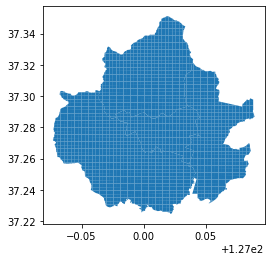

In [82]:
grid_overlay_dataset['geometry'].plot()

In [83]:
suwon_score_data = pd.concat([test_sgg,te_dataset.loc[:,'점수_화재':]],axis=1).loc[:3,:]

<AxesSubplot:xlabel='점수_교통'>

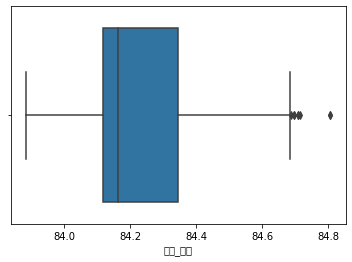

In [84]:
sns.boxplot(grid_overlay_dataset['점수_교통'])

In [85]:
grid_overlay_dataset.loc[:,'점수_화재':'점수_자살'].tail(5)

점수_화재    점수_생활안전      점수_교통      점수_범죄      점수_자살
2238  76.452050  80.343425  84.191326  77.261970  80.807328
2239  76.212070  79.051746  84.079135  73.672640  80.664088
2240  76.212210  78.840772  84.221102  72.615946  80.640680
2241  76.166442  78.881842  83.924280  73.471507  80.672472
2242  76.510632  79.797894  84.199291  76.479368  80.764388

## 3-5 4분위 기준 등급 생성

In [86]:
grid_overlay_dataset['등급_화재']=4
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_화재'] > grid_overlay_dataset['점수_화재'].quantile(0.25)].index,'등급_화재'] = 3
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_화재'] > grid_overlay_dataset['점수_화재'].quantile(0.5)].index,'등급_화재'] = 2
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_화재'] > grid_overlay_dataset['점수_화재'].quantile(0.75)].index,'등급_화재'] = 1

In [87]:
grid_overlay_dataset['등급_생활안전']=4
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_생활안전'] > grid_overlay_dataset['점수_생활안전'].quantile(0.25)].index,'등급_생활안전'] = 3
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_생활안전'] > grid_overlay_dataset['점수_생활안전'].quantile(0.5)].index,'등급_생활안전'] = 2
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_생활안전'] > grid_overlay_dataset['점수_생활안전'].quantile(0.75)].index,'등급_생활안전'] = 1

In [88]:
grid_overlay_dataset['등급_교통']=4
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_교통'] > grid_overlay_dataset['점수_교통'].quantile(0.25)].index,'등급_교통'] = 3
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_교통'] > grid_overlay_dataset['점수_교통'].quantile(0.5)].index,'등급_교통'] = 2
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_교통'] > grid_overlay_dataset['점수_교통'].quantile(0.75)].index,'등급_교통'] = 1

In [89]:
grid_overlay_dataset['등급_범죄']=4
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_범죄'] > grid_overlay_dataset['점수_범죄'].quantile(0.25)].index,'등급_범죄'] = 3
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_범죄'] > grid_overlay_dataset['점수_범죄'].quantile(0.5)].index,'등급_범죄'] = 2
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_범죄'] > grid_overlay_dataset['점수_범죄'].quantile(0.75)].index,'등급_범죄'] = 1

In [90]:
grid_overlay_dataset['등급_자살']=4
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_자살'] > grid_overlay_dataset['점수_자살'].quantile(0.25)].index,'등급_자살'] = 3
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_자살'] > grid_overlay_dataset['점수_자살'].quantile(0.5)].index,'등급_자살'] = 2
grid_overlay_dataset.loc[grid_overlay_dataset[grid_overlay_dataset['점수_자살'] > grid_overlay_dataset['점수_자살'].quantile(0.75)].index,'등급_자살'] = 1

In [91]:
grid_overlay_dataset['점수_화재'].describe()

count    2243.000000
mean       76.228155
std         0.214608
min        75.531782
25%        76.047507
50%        76.242944
75%        76.419088
max        76.725772
Name: 점수_화재, dtype: float64

## 3-6 등급 분포 확인

In [92]:
grid_overlay_dataset['등급_화재'].value_counts()

4    600
1    561
2    560
3    522
Name: 등급_화재, dtype: int64

In [93]:
grid_overlay_dataset['등급_생활안전'].value_counts()

3    561
1    561
4    561
2    560
Name: 등급_생활안전, dtype: int64

In [94]:
grid_overlay_dataset['등급_범죄'].value_counts()

2    606
3    562
4    561
1    514
Name: 등급_범죄, dtype: int64

In [95]:
grid_overlay_dataset['등급_교통'].value_counts()

3    562
1    561
4    561
2    559
Name: 등급_교통, dtype: int64

In [96]:
grid_overlay_dataset['등급_자살'].value_counts()

2    650
3    561
4    561
1    471
Name: 등급_자살, dtype: int64

## 3-7 종합 등급 생성

In [98]:
grid_overlay_dataset['등급_종합'] = (grid_overlay_dataset['등급_화재']+\
                                    grid_overlay_dataset['등급_생활안전']+\
                                    grid_overlay_dataset['등급_교통']+\
                                    grid_overlay_dataset['등급_범죄']+\
                                    grid_overlay_dataset['등급_자살'])/5

In [99]:
grid_overlay_dataset['등급_종합'].value_counts()

2.8    332
2.4    231
2.6    181
3.2    176
3.4    169
1.2    151
3.0    150
3.6    118
1.0    111
1.4    108
1.6    105
2.0    100
1.8     96
2.2     85
3.8     74
4.0     56
Name: 등급_종합, dtype: int64

In [100]:
grid_overlay_dataset

SGG_NM         gid   세대당 인구수  poor_ratio  single_20_ratio  \
0       팔달구  다사53ba22aa  2.299221   54.215651        66.929096   
1       장안구  다사53ba22aa  2.299221   54.215651        66.929096   
2       팔달구  다사53bb21ba  2.299221   46.092354        56.900905   
3       권선구  다사53bb21ba  2.299221   46.092354        56.900905   
4       팔달구  다사53bb21bb  2.299221   10.001385        12.346686   
...     ...         ...       ...         ...              ...   
2238    권선구  다사58bb17ab  2.189820    3.146008        34.047358   
2239    권선구  다사58bb17ba  2.189820    1.183807        12.811635   
2240    권선구  다사58bb17bb  0.000000    0.000000         0.000000   
2241    권선구  다사58bb18aa  2.335097    0.233099        12.242470   
2242    권선구  다사59aa17bb  2.335097    0.985873        51.778447   

      single_65_ratio  single_ratio          성비     외국인 비율     교통신고비율  ...  \
0           64.886931          2.26  161.572052   4.003506  12.658228  ...   
1           64.886931          2.26  161.572052   4.003506  12.658228  ...   
2           55.164723          2.26   93.631179   4.003506   7.462687  ...   
3           55.164723          2.26   93.631179   4.003506   7.462687  ...   
4           11.969960          2.26  155.491329   4.003506  11.428571  ...   
...               ...           ...         ...        ...        ...  ...   
2238        33.833612          0.20   97.707006   4.704615  10.043668  ...   
2239        12.731205          0.20  104.195804   4.704615  47.445255  ...   
2240         0.000000          0.00    0.000000   0.000000  14.285714  ...   
2241         9.719187          0.07   97.674419  10.269916  22.222222  ...   
2242        41.106443          0.07   90.463576  10.269916  35.514019  ...   

          점수_교통      점수_범죄      점수_자살  \
0     84.239714  77.003036  80.906945   
1     84.239714  77.003036  80.906945   
2     84.185284  77.401910  80.762081   
3     84.185284  77.401910  80.762081   
4     84.208734  77.015045  80.888604   
...         ...        ...        ...   
2238  84.191326  77.261970  80.807328   
2239  84.079135  73.672640  80.664088   
2240  84.221102  72.615946  80.640680   
2241  83.924280  73.471507  80.672472   
2242  84.199291  76.479368  80.764388   

                                               geometry  등급_화재  등급_생활안전  \
0     POLYGON ((126.97811 37.28707, 126.97811 37.287...      1        1   
1     POLYGON ((126.97540 37.28903, 126.97822 37.289...      1        1   
2     POLYGON ((126.98107 37.28455, 126.98107 37.283...      1        1   
3     POLYGON ((126.97825 37.28453, 126.98057 37.284...      1        1   
4     POLYGON ((126.98054 37.28458, 126.98028 37.284...      1        1   
...                                                 ...    ...      ...   
2238  POLYGON ((127.03489 37.24646, 127.03771 37.246...      1        1   
2239  POLYGON ((127.03487 37.24871, 127.03769 37.248...      3        4   
2240  POLYGON ((127.03486 37.25097, 127.03768 37.250...      3        4   
2241  POLYGON ((127.03485 37.25322, 127.03767 37.253...      3        4   
2242  POLYGON ((127.03768 37.25098, 127.04050 37.250...      1        2   

      등급_교통  등급_범죄  등급_자살  등급_종합  
0         2      1      1    1.2  
1         2      1      1    1.2  
2         2      1      1    1.2  
3         2      1      1    1.2  
4         2      1      1    1.2  
...     ...    ...    ...    ...  
2238      2      1      1    1.2  
2239      4      4      3    3.6  
2240      2      4      3    3.2  
2241      4      4      3    3.6  
2242      2      2      1    1.6  

[2243 rows x 69 columns]

In [101]:
corr_test = grid_overlay_dataset.loc[:,'점수_화재':'등급_종합']
del corr_test['geometry']

In [102]:
corr_test.corr()

점수_화재   점수_생활안전     점수_교통     점수_범죄     점수_자살     등급_화재   등급_생활안전  \
점수_화재    1.000000  0.684171  0.356832  0.457695  0.474091 -0.942058 -0.677565   
점수_생활안전  0.684171  1.000000  0.176684  0.858124  0.612324 -0.654045 -0.938707   
점수_교통    0.356832  0.176684  1.000000  0.098532  0.221561 -0.356827 -0.204463   
점수_범죄    0.457695  0.858124  0.098532  1.000000  0.562079 -0.402430 -0.786941   
점수_자살    0.474091  0.612324  0.221561  0.562079  1.000000 -0.446704 -0.572885   
등급_화재   -0.942058 -0.654045 -0.356827 -0.402430 -0.446704  1.000000  0.678560   
등급_생활안전 -0.677565 -0.938707 -0.204463 -0.786941 -0.572885  0.678560  1.000000   
등급_교통   -0.320973 -0.118707 -0.908250 -0.058876 -0.202832  0.305903  0.153400   
등급_범죄   -0.466809 -0.834322 -0.164729 -0.914327 -0.562244  0.435632  0.812437   
등급_자살   -0.426870 -0.584534 -0.184619 -0.553297 -0.905618  0.417196  0.564928   
등급_종합   -0.775630 -0.852663 -0.498276 -0.737837 -0.729410  0.776911  0.874730   

            등급_교통     등급_범죄     등급_자살     등급_종합  
점수_화재   -0.320973 -0.466809 -0.426870 -0.775630  
점수_생활안전 -0.118707 -0.834322 -0.584534 -0.852663  
점수_교통   -0.908250 -0.164729 -0.184619 -0.498276  
점수_범죄   -0.058876 -0.914327 -0.553297 -0.737837  
점수_자살   -0.202832 -0.562244 -0.905618 -0.729410  
등급_화재    0.305903  0.435632  0.417196  0.776911  
등급_생활안전  0.153400  0.812437  0.564928  0.874730  
등급_교통    1.000000  0.126674  0.174520  0.482324  
등급_범죄    0.126674  1.000000  0.564644  0.798825  
등급_자살    0.174520  0.564644  1.000000  0.736938  
등급_종합    0.482324  0.798825  0.736938  1.000000

## 3-8 격자 맵 등급 시각화

In [103]:
import branca.colormap as cm
from collections import defaultdict
from folium.plugins import HeatMap
steps = 100
color_map= cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'orange', 'red'], # heatmap 색상연경
    vmin=0.2, vmax=0.9).to_step(n=10)
# color_map

gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

In [104]:
grid_overlay_dataset["x"] = grid_overlay_dataset.centroid.x
grid_overlay_dataset["y"] = grid_overlay_dataset.centroid.y

# Draw a basemap
m = f.Map(location=[37.2766, 127.0286], tiles='openstreetmap', zoom_start=12)

# Add heatmap
HeatMap(
    data=grid_overlay_dataset[['y', 'x','등급_생활안전']], 
    radius=9.7,
    gradient=gradient_map
).add_to(m)

color_map.caption='수원 격자 단위 안전 등급' # colorbar 문구 설정
m.add_child(color_map)

# Display the map
m

## 3-9 격자단위 모델 검증용 분류기

In [105]:
grid_overlay_dataset['점수_종합'] = 0
for i in grid_overlay_dataset.index:
    grid_overlay_dataset.loc[i,'점수_종합'] = grid_overlay_dataset.loc[i,'점수_화재':'점수_자살'].mean()

In [106]:
grid_overlay_dataset['점수_종합'].value_counts()

79.402248    166
79.413005     79
79.429416     24
79.217006     23
79.402705     16
            ... 
79.189927      1
79.539023      1
79.631528      1
78.244732      1
79.632452      1
Name: 점수_종합, Length: 1660, dtype: int64

In [107]:
last_test = grid_overlay_dataset[['SGG_NM', '세대당 인구수', 'poor_ratio', 'single_20_ratio',
       'single_65_ratio', 'single_ratio', '성비', '외국인 비율', '교통신고비율', '기타및서비스비율',
       '절도폭력및경범비율', 'house_ratio', 'report_ratio', 'report_traffic_ratio',
       'report_vio_ratio', 'report_crime_ratio', 'cctv밀도', '보안등밀도', '비상벨밀도',
       '유흥업소밀도', '편의점밀도', '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio',
       '주거지역_use_ratio', '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio',
       'plan_total_area', '공공용지_plan_use_ratio', '공원용지_plan_use_ratio',
       '녹지_plan_use_ratio', '도로용지_plan_use_ratio', '시설용지_plan_use_ratio',
       '업무용지_plan_use_ratio', '주거용지_plan_use_ratio', '학교용지_plan_use_ratio',
       'police_cnt', 'security_cnt', 'remain_area_ratio', 'case_for_sec',
       'OLD_YEAR', 'area_old_level_1', 'area_old_level_2', 'area_old_level_3',
       'area_old_level_4', 'acc_num', 'tot_vic_num', 'total_dmg', '인구10만명당자살율',
       '주민1인당 부담금액', 'PNILP', 'report_for_area', 'sido_경기도', 'sido_경상남도',
       'sido_서울특별시','점수_종합']]

In [108]:
# last_test['등급_종합'] = round(last_test['등급_종합'])

In [109]:
y = last_test['점수_종합']
X = last_test.iloc[:,:-1]

In [110]:
X = pd.get_dummies(X)

In [111]:
X['성비'].value_counts()

0.000000      1123
inf             29
100.000000      14
300.000000       4
97.142857        4
              ... 
96.350365        1
97.685185        1
107.936508       1
100.677966       1
106.077348       1
Name: 성비, Length: 929, dtype: int64

In [112]:
X.loc[X[X['성비']==np.inf].index,'성비'] = 0
X.loc[X[X['case_for_sec']==np.inf].index,'case_for_sec'] = 0
X.loc[X[X['report_vio_ratio']==np.inf].index,'report_vio_ratio'] = 0
X.loc[X[X['report_crime_ratio']==np.inf].index,'report_crime_ratio'] = 0
X.loc[X[X['report_traffic_ratio']==np.inf].index,'report_traffic_ratio'] = 0
X.loc[X[X['report_ratio']==np.inf].index,'report_ratio'] = 0

In [113]:
y.value_counts()

79.402248    166
79.413005     79
79.429416     24
79.217006     23
79.402705     16
            ... 
79.189927      1
79.539023      1
79.631528      1
78.244732      1
79.632452      1
Name: 점수_종합, Length: 1660, dtype: int64

In [114]:
X_tr,X_te,y_tr,y_te = data_spliter(X,y)

In [115]:
model = linear_model.Ridge().fit(X_tr,y_tr)

In [116]:
df = pd.DataFrame(model.predict(X_te))

In [117]:
pred = model.predict(X_te)

In [118]:
metrics.mean_absolute_error(y_te,pred)

0.18251200577605328

### 3-10 가중치 확인

In [122]:
coef = model.coef_
coedf = pd.DataFrame(coef)
coedf.columns = ['coef']
coedf['col'] = X.columns
coedf.sort_values('coef',ascending=True)

<hr>

## 4. 취약지역 솔루션

### 종합적으로 산출된 w와 각 지역의 x를 연산하여, 해당 지역에 어떤 특성이 안전지수에 큰 영향을 주는지 판단 가능

In [136]:
pandan = []
for i in range(len(np.array(X.loc[2200,:]))):
    pandan.append(np.array(coedf['coef'])[i] * np.array(X.loc[2200,:])[i] )
    
coedf['row_2200'] = np.array(X.loc[2200,:])
coedf['test_2200_row'] = pandan

In [145]:
coedf.sort_values("test_2200_row",ascending=True)

coef                   col  test_2200_row       row_2200
10 -1.197810e-02           house_ratio      -0.955014      79.730000
6  -6.526227e-02                외국인 비율      -0.307034       4.704615
9  -5.392771e-03             절도폭력및경범비율      -0.227695      42.222222
8  -1.822424e-03              기타및서비스비율      -0.093146      51.111111
49 -9.963526e-08            주민1인당 부담금액      -0.085934  862490.000000
7  -5.258853e-03                교통신고비율      -0.035059       6.666667
51 -3.097194e-05       report_for_area      -0.022283     719.455207
4  -6.202314e-02          single_ratio      -0.012405       0.200000
15 -2.150365e-04                cctv밀도      -0.010314      47.963680
45 -4.868885e-04               acc_num      -0.004760       9.775568
1  -1.531192e-03            poor_ratio      -0.004525       2.955464
5  -4.304389e-05                    성비      -0.004075      94.659546
27 -4.430602e-02       plan_total_area      -0.002595       0.058570
47 -1.403972e-08             total_dmg      -0.002506  178518.000393
11 -8.428109e-05          report_ratio      -0.000253       3.000000
58 -1.344766e-02            SGG_NM_팔달구      -0.000000       0.000000
42 -7.050504e-02      area_old_level_2      -0.000000       0.000000
41  1.388792e-02      area_old_level_1       0.000000       0.000000
40 -4.593818e-03              OLD_YEAR      -0.000000       0.000000
39 -2.862488e-04          case_for_sec      -0.000000       0.000000
38  7.921873e-04     remain_area_ratio       0.000000       0.000000
37 -1.991383e-01          security_cnt      -0.000000       0.000000
36 -1.991383e-01            police_cnt      -0.000000       0.000000
35  3.070496e-03   학교용지_plan_use_ratio       0.000000       0.000000
56  9.192506e-03            SGG_NM_영통구       0.000000       0.000000
33  1.267915e-03   업무용지_plan_use_ratio       0.000000       0.000000
32 -1.819040e-04   시설용지_plan_use_ratio      -0.000000       0.000000
13 -6.080377e-04      report_vio_ratio      -0.000000       0.000000
43  8.297221e-03      area_old_level_3       0.000000       0.000000
57 -7.884959e-03            SGG_NM_장안구      -0.000000       0.000000
54  0.000000e+00            sido_서울특별시       0.000000       0.000000
26  0.000000e+00        농경지역_use_ratio       0.000000       0.000000
25  0.000000e+00          기타_use_ratio       0.000000       0.000000
24 -6.411145e-02        공업지역_use_ratio      -0.000000       0.000000
22 -3.422790e-01        상업지역_use_ratio      -0.000000       0.000000
52  0.000000e+00              sido_경기도       0.000000       1.000000
53  0.000000e+00             sido_경상남도       0.000000       0.000000
19 -6.944766e-04                 편의점밀도      -0.000000       0.000000
18 -2.390227e-03                유흥업소밀도      -0.000000       0.000000
17  1.402692e-03                 비상벨밀도       0.000000       0.000000
16 -6.548897e-06                 보안등밀도      -0.000000       0.000000
12 -1.375690e-03  report_traffic_ratio      -0.000000       0.000000
28  1.507032e-03   공공용지_plan_use_ratio       0.000000       0.000000
44 -3.671968e-03      area_old_level_4      -0.000000       0.000000
31  4.484543e-04   도로용지_plan_use_ratio       0.000187       0.416143
30  1.514196e-04     녹지_plan_use_ratio       0.000734       4.845525
14  1.204040e-03    report_crime_ratio       0.001204       1.000000
29  1.206899e-03   공원용지_plan_use_ratio       0.001906       1.578918
21  2.522128e-02        녹지지역_use_ratio       0.002611       0.103516
46  1.759579e-02           tot_vic_num       0.006217       0.353334
48  2.780071e-04            인구10만명당자살율       0.007034      25.300000
50  1.745173e-08                 PNILP       0.011306  647850.170648
55  1.214012e-02            SGG_NM_권선구       0.012140       1.000000
20  5.173901e-04             공원및놀이시설밀도       0.024816      47.963680
23  5.723033e-02        주거지역_use_ratio       0.051306       0.896484
2   2.762533e-03       single_20_ratio       0.088360      31.985212
34  1.307652e-03   주거용지_plan_use_ratio       0.121820      93.159414
3   1.1198